# FASER Reach Estimator - Dark Photon

### Load Libraries 

In [1]:
import numpy as np
from src.foresee import Foresee

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

If dark photons are sufficiently light, they are mainly produced via pion decay. To start, let us have a look at the pion spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi^0$, $\eta$, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. 

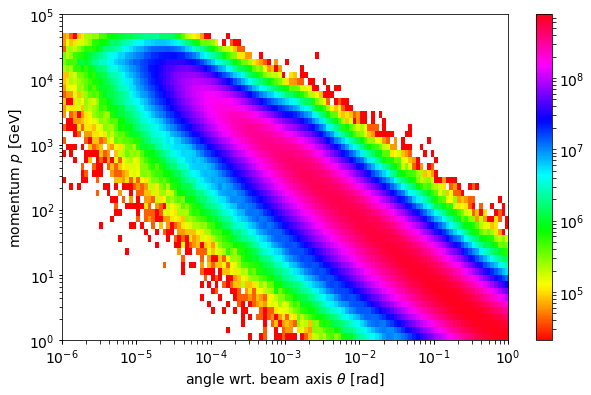

In [5]:
plt=foresee.get_spectrumplot(pid="221", generator="EPOSLHC", energy="100")
plt.show()

### 1.  Particle Production

Let us look at the kinematic distribution of a dark photon produced at the LHC. The dark photon kinematics is described by four variables (for example px,py,pz,E), out of which two are interesting. Here I choose the dark photon momentum $p$ and the angle with respect to the beam axis $\theta$. Let's plot them for a benchmark point with $m_{A'}=100$ MeV. 

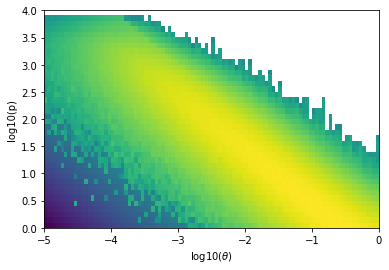

In [2]:
p,w=convert_list_to_momenta("files/llpspectra/DarkPhoton_LHC_m_0.1.npy",filetype="npy",mass=0.1)
_=convert_to_hist_list(p,w,do_plot=True)

The default radial size of FASER2 is $R=1$ meter, which corresponds to $\theta=2$ mrad. Let us look for one specific dark photon mass m_{A'}=100$ MeV how many particle decay inside the decay volume. The decay volume is assumed to be cylindrical and specified by

- the `radius` in units of meter (default: 1)
- the `length` in units of meter (default: 5)
- the `offset` between the detectors center and the beam axis in units of meter (default: 0)
- the `luminosity` in units of fb^-1 (default: 3000)

Additionally, we can restrict the detectable decay channels via the `channel` option. It can be set to an array containing `"e_e"`,  `"mu_mu"`,`"pi+_pi-"`, `"pi0_gamma"`, `"K_K"`, `"pi+_pi-_pi0"`, `"K_K_pi"`, `"pi+_pi-_pi+_pi-"` and/or `"pi+_pi-_pi0_pi0"`. By default, `channels=None` which includes all decay channels. 

Let us look at the event rate for different values of the coupling $\epsilon$

In [3]:
radius=1 #in meter
length=5 #in meter
offset=0 #in meter
luminosity=3000 #in fb^-1

evtcounter=MyEventCounter(model="DarkPhoton",mass=0.1,ncoup=5,
    radius=radius, length=length, offset=offset, lumi=luminosity)
coups, ctaus, nsigs, energies, weights, _ = evtcounter.do_convolution()
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print "epsilon =",coup, ": nsig =", nsig

epsilon = 1e-08 : nsig = 2.1468146086983727e-06
epsilon = 1e-07 : nsig = 0.021401243674573914
epsilon = 1e-06 : nsig = 158.31528586938376
epsilon = 1e-05 : nsig = 1065.4206442197565
epsilon = 0.0001 : nsig = 1.6749461088003654e-29
epsilon = 0.001 : nsig = 0.0


The previous function also outputs the energy distribution of the dark photons which decay inside the detector. Let's have a look at them.

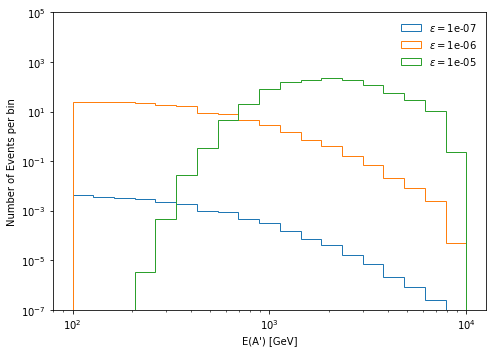

In [4]:
fig = plt.figure(figsize=(7,5))

ax = plt.subplot(1,1,1)
for coup,energy,weight in zip(coups,energies,weights):
    if sum(weight)<10**-5 : continue
    ax.hist(
        energy,weights=weight, 
        bins=np.logspace(np.log10(100),np.log10(10000), 20),
        histtype='step',
        label=r"$\epsilon=$"+str(coup)
    ) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(0.0000001,100000) 
    ax.set_xlabel("E(A') [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False)
plt.tight_layout()
plt.show()

### 2. Particle Decay

I wrote a simple module, that uses Pythia to generate LLP decays. It returns an array of events consisting of particles characterized by `[PID, pX, pY, pZ, E]` in the dark photons rest frame. Let's generate some events and save them to a file. 

**Note:** You need to have the Pythia Python library installed. Assuming that this is not the case, I just commented this part out.  

In [5]:
#for mass in [0.25,0.5,0.75,1,1.25,1.5,1.75,2]:
#    gen=LLPGenerator(model="DarkPhoton")
#    events = gen.simulate_events( mass=mass, nevent=100,
#        outputfile="files/llpdecay/DarkPhoton_"+str(mass)+".npy",
#    )

I already generated some `DarkPhoton` events for masses `mass=0.25`, `0.5`, `0.75`, `1`, `1.25`, `1.5`, `1.75` and `2` GeV, and saved them as `.npy` file. Let's
- i) load a sample of dark photons decay products with mass of 0.75 GeV, 
- ii) convert them in LorentzVectors and 
- iii) boost them in the lab frame . 

Here I show `nevent=5` dark photon decay events for dark photons  `mass=0.75` GeV and `energy=1000` GeV. 

In [6]:
#Specify Event
mass   = 0.75
energy = 1000
nevent = 5

#Load Events
events = np.load("files/llpdecay/DarkPhoton_"+str(mass)+".npy")

#Create Lorentzvector for LLP
llp = LorentzVector(0,0,np.sqrt(energy**2 - mass**2),energy)

#Loop Through Events 
for i,event in enumerate(events):
    if i>=nevent: break
    print "Event "+str(i+1)
    for pid, px,py,pz,en in event:
        particle = LorentzVector(px,py,pz,en)
        print pid, ": ", particle.boost(-1.*llp.boostvector)
    print ""

Event 1
-211.0 :  (0.3136901935349339, 0.14646298606216956, 452.0689592630967, 452.06911336868404)
211.0 :  (-0.3136901935349339, -0.14646298606216956, 547.9307595650045, 547.9308867094567)

Event 2
-211.0 :  (-0.1446072836286496, -0.24873027859983488, 238.83257497253362, 238.83278905086235)
211.0 :  (0.1446072836286496, 0.24873027859983488, 761.1671438555676, 761.1672110272783)

Event 3
-211.0 :  (-0.18290234304169478, 0.18879961994003858, 804.1829958550634, 804.1830509285638)
211.0 :  (0.18290234304169478, -0.18879961994003858, 195.81672297303783, 195.81694914957671)

Event 4
-211.0 :  (0.31620782150675314, -0.07120024606653816, 669.1196916463448, 669.1197847064049)
211.0 :  (-0.31620782150675314, 0.07120024606653816, 330.8800271817565, 330.88021537173574)

Event 5
-211.0 :  (0.06647931182696584, 0.3094993602209812, 307.07679023263, 307.07698511727057)
211.0 :  (-0.06647931182696584, -0.3094993602209812, 692.9229285954711, 692.92301496087)



Let's also have a look at the branching fraction. The lines correspond to the branching fractions obtained in [1801.04847](https://arxiv.org/abs/1801.04847), which are obtaiend through a fit to electron scattering data. I modified Pythia such that it can reproduce these results, as shown through the data points. 

**Note:** By default, Pythia's $Z'$ model onluy specifies the partonic branching fractions and then uses Pythia's hadronization model. This typically gives wrong results. Below, I use Pythia's hadronization model for $m_{A'}>1.5$ GeV. In the future, I will add the results from [1911.11147](https://arxiv.org/abs/1911.11147) which extend the dark photon BR to more channels and higher masses.  

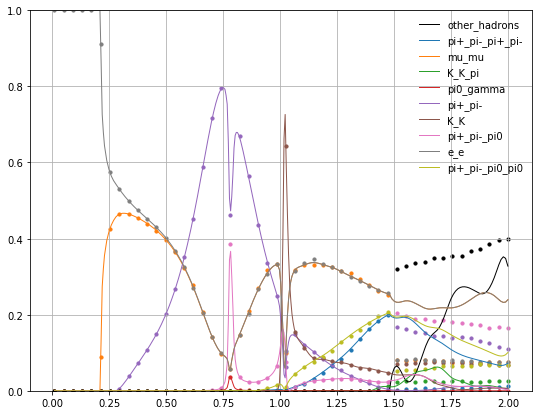

In [7]:
_=br_validation_plot(model="DarkPhoton",massmin=0.01, massmax=2.0)

### 3. Parameter Scan

In the following, we get the reach for different setups of the detector, as specified by `radius`, `length`, `offset`, `luminosity` and `channels`. As an example, I show how the FASER2 reach changes when we displace the detector by 2 meter from the beam axis. The results will be written into a `.npy` file that we can store and plot later.

In [8]:
#specify setup
setup="FASER"
radius=0.1
length=1.5
offset=0
luminosity=150 
channels = None #["e_e"]

#get reach 
masses=[0.002,0.003,0.005,0.01,0.015,0.02,0.03,0.04,0.05,0.06,0.07,0.1,
        0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1, 
        1.1,1.2,1.3,1.4,1.5,1.7,2,2.5,3,4,5]
nsignals=[]    
for mass in masses:
    nsigs=None
    evtcounter=MyEventCounter(
        model="DarkPhoton",mass=mass,nphisample=10,
        radius=radius, length=length, offset=offset, lumi=luminosity,
        channels = channels
    )
    couplings, _, nsigs, _, _ , _= evtcounter.do_convolution()
    if nsigs is None: nsigs=0
    nsignals.append(nsigs)  
    
#save results
np.save("files/results/DarkPhoton_"+setup+".npy",[masses,couplings,nsignals])

Now let's plot the results. Here I show 
- the `default` setup (5 meter long, 1 meter radius, no offset, all decay channels, 3000 fb$^{-1}$).
- the `2-m-offset` setup (5 meter long, 1 meter radius, 2m offset, all decay channels, 3000 fb$^{-1}$).
- the `leptonic` setup (5 meter long, 1 meter radius, no offset, only leptonicdecay channels, 3000 fb$^{-1}$).

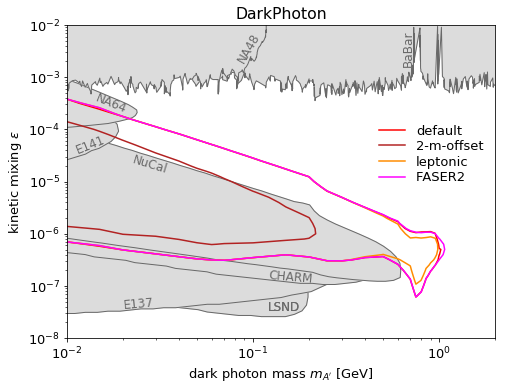

In [9]:
plot_reach(model="DarkPhoton",setups=["default","2-m-offset","leptonic","FASER2"],
    include_default=False,label="DarkPhoton",bbox_to_anchor=(1,0.72))

### Nicer looking plot with other experiments

We can also make a plot including other future experiments sensitivity. 

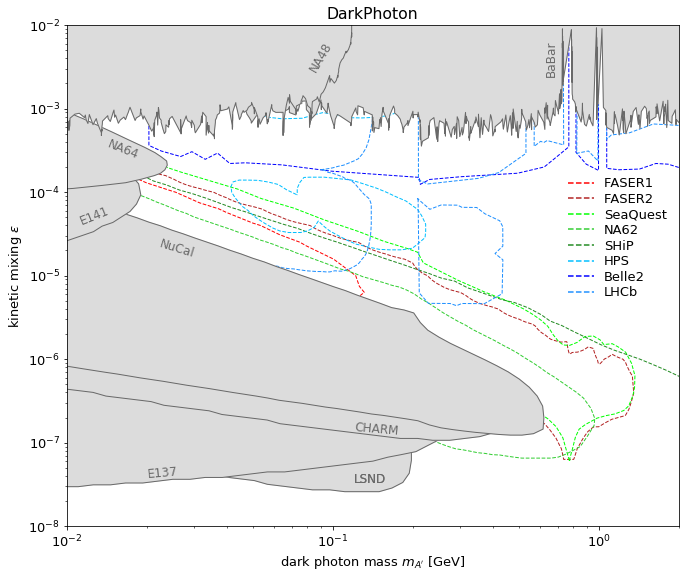

In [10]:
plot_reach(model="DarkPhoton",setups=[],
    include_default=False,label="DarkPhoton", show_future=True,figsize=(10,8),
    frameon=False,bbox_to_anchor=(1,0.72))

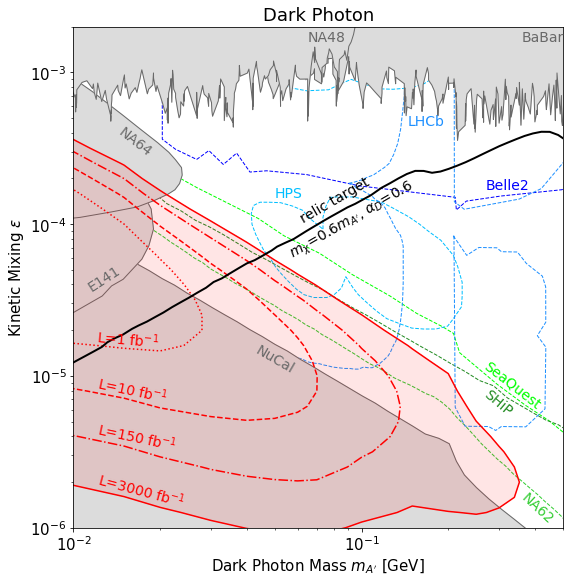

In [109]:
def plot_reach_new(setups, show_future=False,
    figsize=(7,5),bbox_to_anchor=None, frameon=False, do_legend=True,setuplabels=None):
    
    #load data
    massesv, couplingsv, nsignalsv = [],[],[]
    for setup in setups:
        masses,couplings,nsignals=np.load("files/results/DarkPhoton_"+setup+".npy")
        massesv.append(masses)
        couplingsv.append(couplings)
        nsignalsv.append(nsignals)
    if setuplabels==None: setuplabels=setups
    
    #initiate figure
    matplotlib.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(figsize=figsize)
    zorder=-100
    colors = ["dodgerblue""firebrick"]
    
    #existing bounds
    limits=[["SeaQuest",     "dashed",  "lime",         1 ],
            ["NA62",         "dashed",  "limegreen",    1 ],
            ["SHiP",         "dashed",  "forestgreen",  1 ],
            ["HPS",          "dashed",  "deepskyblue",  1 ],
            ["HPS-1",        "dashed",  "deepskyblue",  0 ],
            ["Belle2",       "dashed",  "blue",         1 ],
            ["LHCb",         "dashed",  "dodgerblue",   1 ],
            ["LHCb-mumu1",   "dashed",  "dodgerblue",   0 ],
            ["LHCb-mumu2",   "dashed",  "dodgerblue",   0 ],
        ]
    if show_future:
        for limit in limits:
            bound_file=readfile("files/DarkPhoton/bounds/limits_"+limit[0]+".txt")
            ax.plot(bound_file.T[0], bound_file.T[1], color=limit[2], ls=limit[1], zorder=zorder, lw=1)
            if limit[3]==1: ax.plot([10**-10],[10**-10],color=limit[2], ls=limit[1],label=limit[0])
            zorder+=1
            
    #Future Constraints - Text
    fontsizelab = 14
    plt.text(0.260, 1.1*10**-5, "SeaQuest", fontsize=fontsizelab, color="lime"       ,rotation=-38)
    plt.text(0.350, 1.5*10**-6, "NA62"    , fontsize=fontsizelab, color="limegreen"  ,rotation=-43)
    plt.text(0.260, 7.2*10**-6, "SHiP"    , fontsize=fontsizelab, color="forestgreen",rotation=-40)
    plt.text(0.050, 1.5*10**-4, "HPS"     , fontsize=fontsizelab, color="deepskyblue",rotation=0)
    plt.text(0.270, 1.7*10**-4, "Belle2"  , fontsize=fontsizelab, color="blue"       ,rotation=0)
    plt.text(0.145, 4.5*10**-4, "LHCb"    , fontsize=fontsizelab, color="dodgerblue" ,rotation=0)

    #existing bounds
    bounds=["LSND","E137","Charm","NuCal","E141","NA64","BaBar","NA48"]
    for bound in bounds:
        bound_file=readfile("files/DarkPhoton/bounds/bounds_"+bound+".txt")
        ax.fill(bound_file.T[0], bound_file.T[1], color="gainsboro",zorder=zorder)
        ax.plot(bound_file.T[0], bound_file.T[1], color="dimgray"  ,zorder=zorder,lw=1)
        zorder+=1
        
    #Existing Constraints - Text
    fontsizelab = 14
    plt.text(0.360, 1.6*10**-3, "BaBar", fontsize=fontsizelab,color="dimgray",rotation=0)
    plt.text(0.065, 1.6*10**-3, "NA48",  fontsize=fontsizelab,color="dimgray",rotation=0)
    plt.text(0.014, 3.8*10**-4, "NA64",  fontsize=fontsizelab,color="dimgray",rotation=-38)
    plt.text(0.011, 4.7*10**-5, "E141",  fontsize=fontsizelab,color="dimgray",rotation=33)
    plt.text(0.042, 1.4*10**-5, "NuCal", fontsize=fontsizelab,color="dimgray",rotation=-30)
    #plt.text(0.120, 3.3*10**-8, "LSND",  fontsize=fontsizelab,color="dimgray",rotation=0)
    #plt.text(0.120, 1.4*10**-7, "CHARM", fontsize=fontsizelab,color="dimgray",rotation=-5)
    #plt.text(0.020, 4.1*10**-8, "E137",  fontsize=fontsizelab,color="dimgray",rotation=5)
    
    #FASER limits
    linestyles=["solid","dashdot","dashed","dotted"]
    colors = ["red","firebrick","darkorange","magenta","gold","darkmagenta"]
    levels = [np.log10(3./20.),np.log10(3),np.log10(3*15),np.log10(3*150)]
    for i,(setup,color,linelabel) in enumerate(zip(setups,colors,setuplabels)):
        masses=massesv[i]
        couplings=couplingsv[i]
        nsignals=nsignalsv[i]
        m, c = np.meshgrid(masses, couplings)
        n=np.log10(np.array(nsignals).T+1e-20)
        ax.contour(m,c,n, levels=levels,colors=color,zorder=zorder, linestyles=linestyles)
        ax.contourf(m, c, n, levels=[levels[0],10**10],colors=colors[i],zorder=zorder,alpha=0.1)
        #ax.plot([10**-10],[10**-10],color=color,label=linelabel)
        #ax.plot([10**-10],[10**-10],color=color_def,linestyle="dashed",label="default")
        zorder+=1
    
    # DM line
    data = readfile("files/DarkPhoton/scalar_DM_Oh2_intermediate_eps_vs_mAprime.txt")
    ax.plot(data.T[0], data.T[1], color="k", zorder=zorder, lw=2)
    plt.text(0.060, 1.80*10**-4, "relic target",  fontsize=fontsizelab,color="k",rotation=30)
    plt.text(0.055, 1.69*10**-4, r"$m_\chi\!=\!0.6 m_{A'}$, $\alpha_D\!=\!0.6$",  
             fontsize=fontsizelab,color="k",rotation=30)
    
    # text FASER
    plt.text(0.012, 1.65*10**-5, r"L=1 fb$^{-1}$",  fontsize=fontsizelab,color="red",rotation=-5)
    plt.text(0.012, 8.20*10**-6, r"L=10 fb$^{-1}$",  fontsize=fontsizelab,color="red",rotation=-12)
    plt.text(0.012, 4.10*10**-6, r"L=150 fb$^{-1}$",  fontsize=fontsizelab,color="red",rotation=-12)
    plt.text(0.012, 1.90*10**-6, r"L=3000 fb$^{-1}$",  fontsize=fontsizelab,color="red",rotation=-15)
    
    #frame
    ax.set_title("Dark Photon")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(0.01,0.5)
    ax.set_ylim(10**-6,0.002)
    ax.set_xlabel(r"Dark Photon Mass $m_{A'}$ [GeV]")
    ax.set_ylabel(r"Kinetic Mixing $\epsilon$")
    
    #if do_legend: ax.legend(loc="upper right", bbox_to_anchor=bbox_to_anchor, frameon=frameon, labelspacing=0.2)
    plt.subplots_adjust(left=0.12, right=0.97, bottom=0.11, top=0.98)
    plt.savefig("/Users/felixkling/Downloads/Figure.pdf")

plot_reach_new(setups=["FASER"],
    show_future=True, figsize=(8,8), frameon=False, bbox_to_anchor=(1,0.72))